In [4]:

from simulator.reporters import TransitionReporter
from simulator.core import Task
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from simulator import Config

In [5]:
def loadDataframe(batchId: str) -> pd.DataFrame:
    reportMap = None
    with open(
        "results/reportMaps/reportMap{id}.json".format(id = batchId),
        "r") as reportFile:
        reportMap = json.load(reportFile)
    
    # Finding all config changes
    configList = set()
    for report in reportMap:
        varients = report["varient"]
        for varient in varients:
            configList.add(varient["config"])
            
    tupleTemplate = {}
    for config in configList:
        tupleTemplate[config] = Config.get(config)
        tupleTemplate[config + "_default"] = True
    print(tupleTemplate)
    
    tupleList = []
    for report in reportMap:
        reportTupleTemplate = tupleTemplate.copy()
        runId = report["runId"]
        varients = report["varient"]
        for varient in varients:
            config = varient["config"]
            reportTupleTemplate[config] = varient["value"]
            reportTupleTemplate[config + "_default"] = False
        reportTupleTemplate["run_id"] = runId
        
        mobileReport = TransitionReporter.getListFromPickle("results/report/{batchId}/reportmobile{runId}.pkl".format(batchId = batchId, runId = runId))
        for item in mobileReport:
            tuple = reportTupleTemplate.copy()
            tuple["task_id"] = item.task.id()
            tuple["arrival_time"] = item.task.arrivalTime()
            tuple["delay"] = item.delay
            tuple["power"] = item.powerConsumtion
            tuple["reward"] = item.reward
            tuple["action"] = item.action
            tuple["hopLimit"] = item.task.hopLimit()
            tupleList.append(tuple)
            
    df = pd.DataFrame(tupleList)
    # unify action values
    df["action"] = df["action"].apply(lambda x: 0 if ("0" in str(x)) else (1 if ("1" in str(x)) else x))
    
    return df

In [6]:
df = loadDataframe("A")

{'mobile_selector': 'dql', 'mobile_selector_default': True, 'edge_selector': 'dql', 'edge_selector_default': True, 'boxworld_mobile_nodes': 50, 'boxworld_mobile_nodes_default': True, 'task_generator_lambda': 0.5, 'task_generator_lambda_default': True}


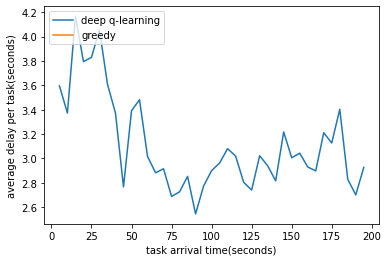

In [8]:
vairable_conditions = {
    "deep q-learning": (df["mobile_selector"] == "dql") & (df["edge_selector"] == "dql"),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy")
}
vairable_conditions1 = {
    "50": (df["boxworld_mobile_nodes"] == 50) & (df["mobile_selector"] == "dql") & (df["edge_selector"] == "dql"),
    "100": (df["boxworld_mobile_nodes"] == 100) & (df["mobile_selector"] == "dql") & (df["edge_selector"] == "dql"),
    "150": (df["boxworld_mobile_nodes"] == 150) & (df["mobile_selector"] == "dql") & (df["edge_selector"] == "dql"),
    "200": (df["boxworld_mobile_nodes"] == 200) & (df["mobile_selector"] == "dql") & (df["edge_selector"] == "dql"),
    "300": (df["boxworld_mobile_nodes"] == 300) & (df["mobile_selector"] == "dql") & (df["edge_selector"] == "dql"),
    "400": (df["boxworld_mobile_nodes"] == 400) & (df["mobile_selector"] == "dql") & (df["edge_selector"] == "dql")
}
vairable_conditions2 = {
    "50": (df["boxworld_mobile_nodes"] == 50) & (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "100": (df["boxworld_mobile_nodes"] == 100) & (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "150": (df["boxworld_mobile_nodes"] == 150) & (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "200": (df["boxworld_mobile_nodes"] == 200) & (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "300": (df["boxworld_mobile_nodes"] == 300) & (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "400": (df["boxworld_mobile_nodes"] == 400) & (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy")
}
vairable_conditions3 = {
    "greedy": (df["boxworld_mobile_nodes"] == 100) & (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & 
    (df["task_generator_lambda"] == 0.5),
    "dql": (df["boxworld_mobile_nodes"] == 100) & (df["mobile_selector"] == "dql") & (df["edge_selector"] == "dql") & 
    (df["task_generator_lambda"] == 0.5)
}
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = value
    data = df.loc[item_condition, ["delay"]].groupby(
        pd.cut(df["arrival_time"], np.arange(0, 200, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data)

plt.ylabel('average delay per task(seconds)')
plt.xlabel('task arrival time(seconds)')
plt.legend(graphs.keys(), loc='upper left')